In [1]:
import os
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
                         # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.seasonal import seasonal_decompose

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import seaborn as sns
sns.set_style(
    style='whitegrid', 
    rc={'axes.facecolor': '.95', 'grid.color': '.95'}
)

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.random.set_seed(2)

from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten, GRU

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

os.environ['PYTHONHASHSEED'] = str(2)
np.random.seed(2)

In [2]:
df = pd.read_csv('output.csv')
df.head()

,time,Toffice_reference,humidity,detected_motions,occupancy,office_CO2_concentratio,door,label
0,2015-01-06 15:00:00,19.45,42.0,0,0.0,469.265967,1.00000,1.128000
1,2015-01-06 15:05:00,19.45,42.0,0,0.0,448.187067,1.00000,0.622000
2,2015-01-06 15:10:00,19.45,42.0,0,0.0,454.433067,1.00000,0.634000
3,2015-01-06 15:15:00,19.45,42.0,1,0.0,457.387200,0.39944,0.285733
4,2015-01-06 15:20:00,19.45,42.0,0,0.0,444.462833,0.00000,0.094000


In [3]:
df.tail()

,time,Toffice_reference,humidity,detected_motions,occupancy,office_CO2_concentratio,door,label
102925,2015-12-30 00:05:00,18.35,33.0,0,0.0,430.0,0.0,0.01
102926,2015-12-30 00:10:00,18.35,33.0,0,0.0,430.0,0.0,0.01
102927,2015-12-30 00:15:00,18.35,33.0,0,0.0,430.0,0.0,0.01
102928,2015-12-30 00:20:00,18.35,33.0,0,0.0,430.0,0.0,0.01
102929,2015-12-30 00:25:00,18.35,33.0,0,0.0,430.0,0.0,0.01


In [4]:
#Find missing data!
pd.date_range('2015-01-06 15:00:00', '2015-12-30 00:25:00', freq='5Min').difference(pd.to_datetime(df["time"]))

DatetimeIndex(['2015-03-29 02:00:00', '2015-03-29 02:05:00',
               '2015-03-29 02:10:00', '2015-03-29 02:15:00',
               '2015-03-29 02:20:00', '2015-03-29 02:25:00',
               '2015-03-29 02:30:00', '2015-03-29 02:35:00',
               '2015-03-29 02:40:00', '2015-03-29 02:45:00',
               '2015-03-29 02:50:00', '2015-03-29 02:55:00'],
              dtype='datetime64[ns]', freq=None)

In [5]:
df.isna().sum()

time                       0
Toffice_reference          0
humidity                   0
detected_motions           0
occupancy                  0
office_CO2_concentratio    0
door                       0
label                      0
dtype: int64

In [6]:
df["time"]= pd.to_datetime(df["time"])
df.set_index(["time"], inplace=True)
df.head()

,Toffice_reference,humidity,detected_motions,occupancy,office_CO2_concentratio,door,label
time,,,,,,,
2015-01-06 15:00:00,19.45,42.0,0,0.0,469.265967,1.00000,1.128000
2015-01-06 15:05:00,19.45,42.0,0,0.0,448.187067,1.00000,0.622000
2015-01-06 15:10:00,19.45,42.0,0,0.0,454.433067,1.00000,0.634000
2015-01-06 15:15:00,19.45,42.0,1,0.0,457.387200,0.39944,0.285733
2015-01-06 15:20:00,19.45,42.0,0,0.0,444.462833,0.00000,0.094000


In [7]:
df.drop(['Toffice_reference', 'humidity', 'detected_motions', 'occupancy', 'office_CO2_concentratio','door'], axis=1, inplace=True)

In [8]:
df.head()

,label
time,
2015-01-06 15:00:00,1.128000
2015-01-06 15:05:00,0.622000
2015-01-06 15:10:00,0.634000
2015-01-06 15:15:00,0.285733
2015-01-06 15:20:00,0.094000


In [9]:
df[df['label']<0] = 0

In [10]:
df[df['label']<0]

,label
time,


In [11]:
data_per_5min = df
data_per_Hour = df.resample('H').sum()
data_per_5min.shape, data_per_Hour.shape

((102930, 1), (8578, 1))

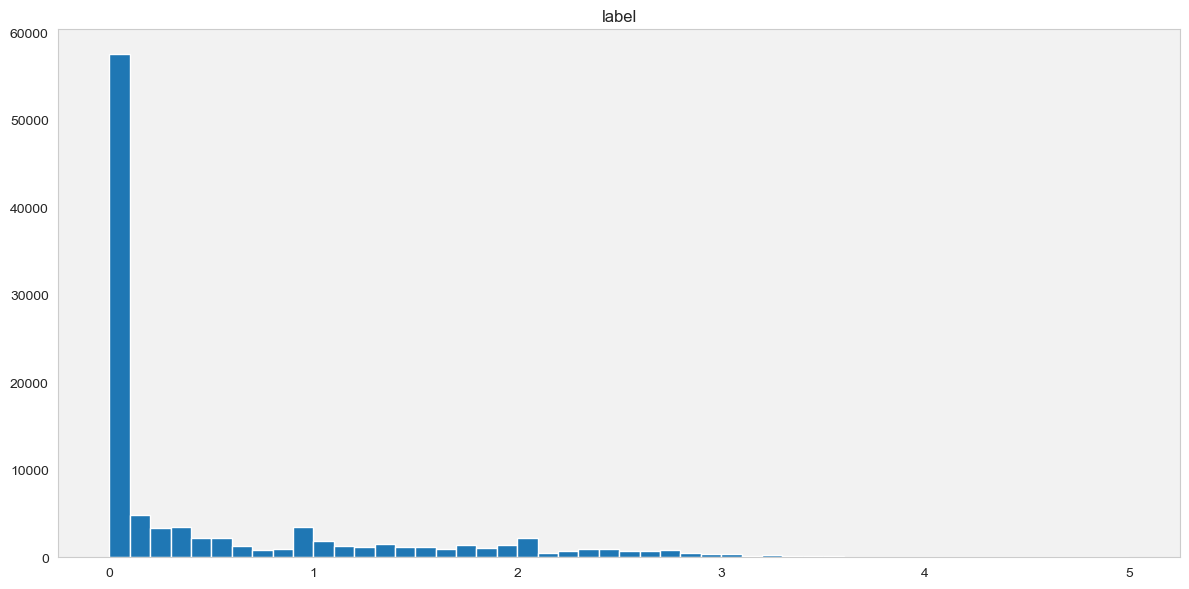

In [12]:
df.hist(bins=50)
plt.tight_layout()

<AxesSubplot:ylabel='label'>

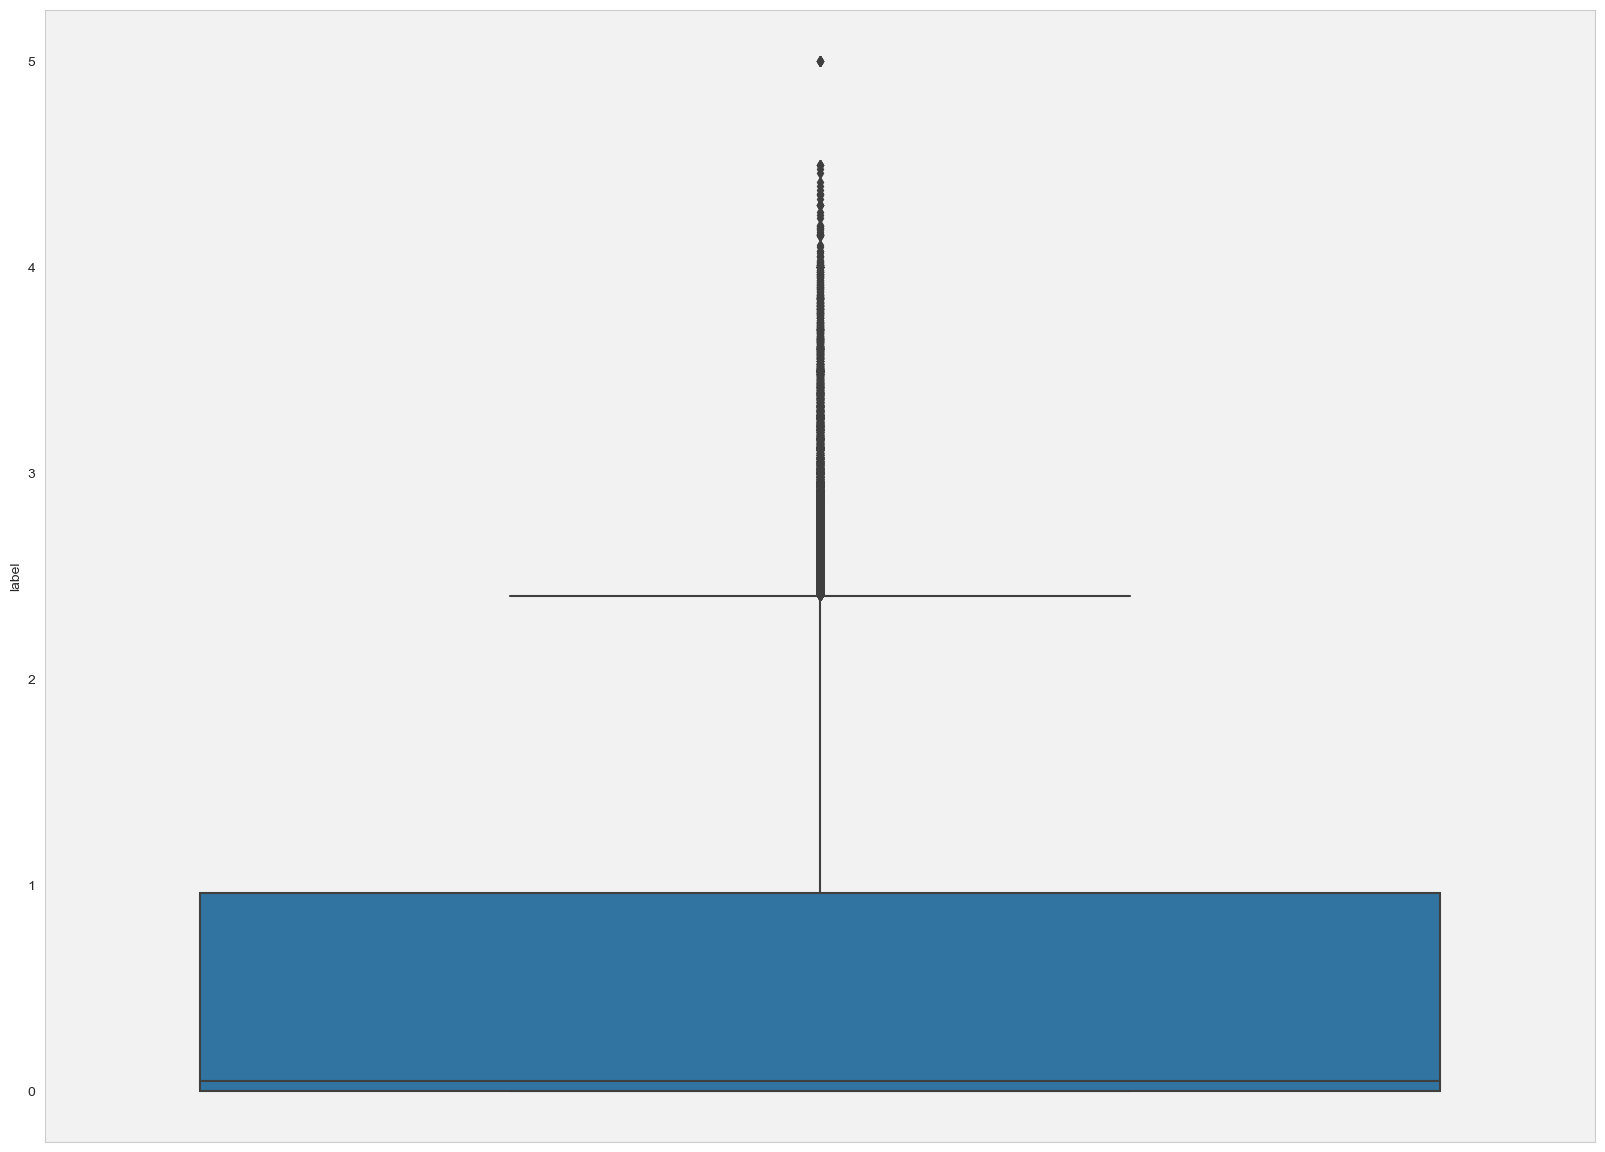

In [13]:
fig = plt.figure(figsize=(20, 15))
sns.boxplot(data=df, y='label')



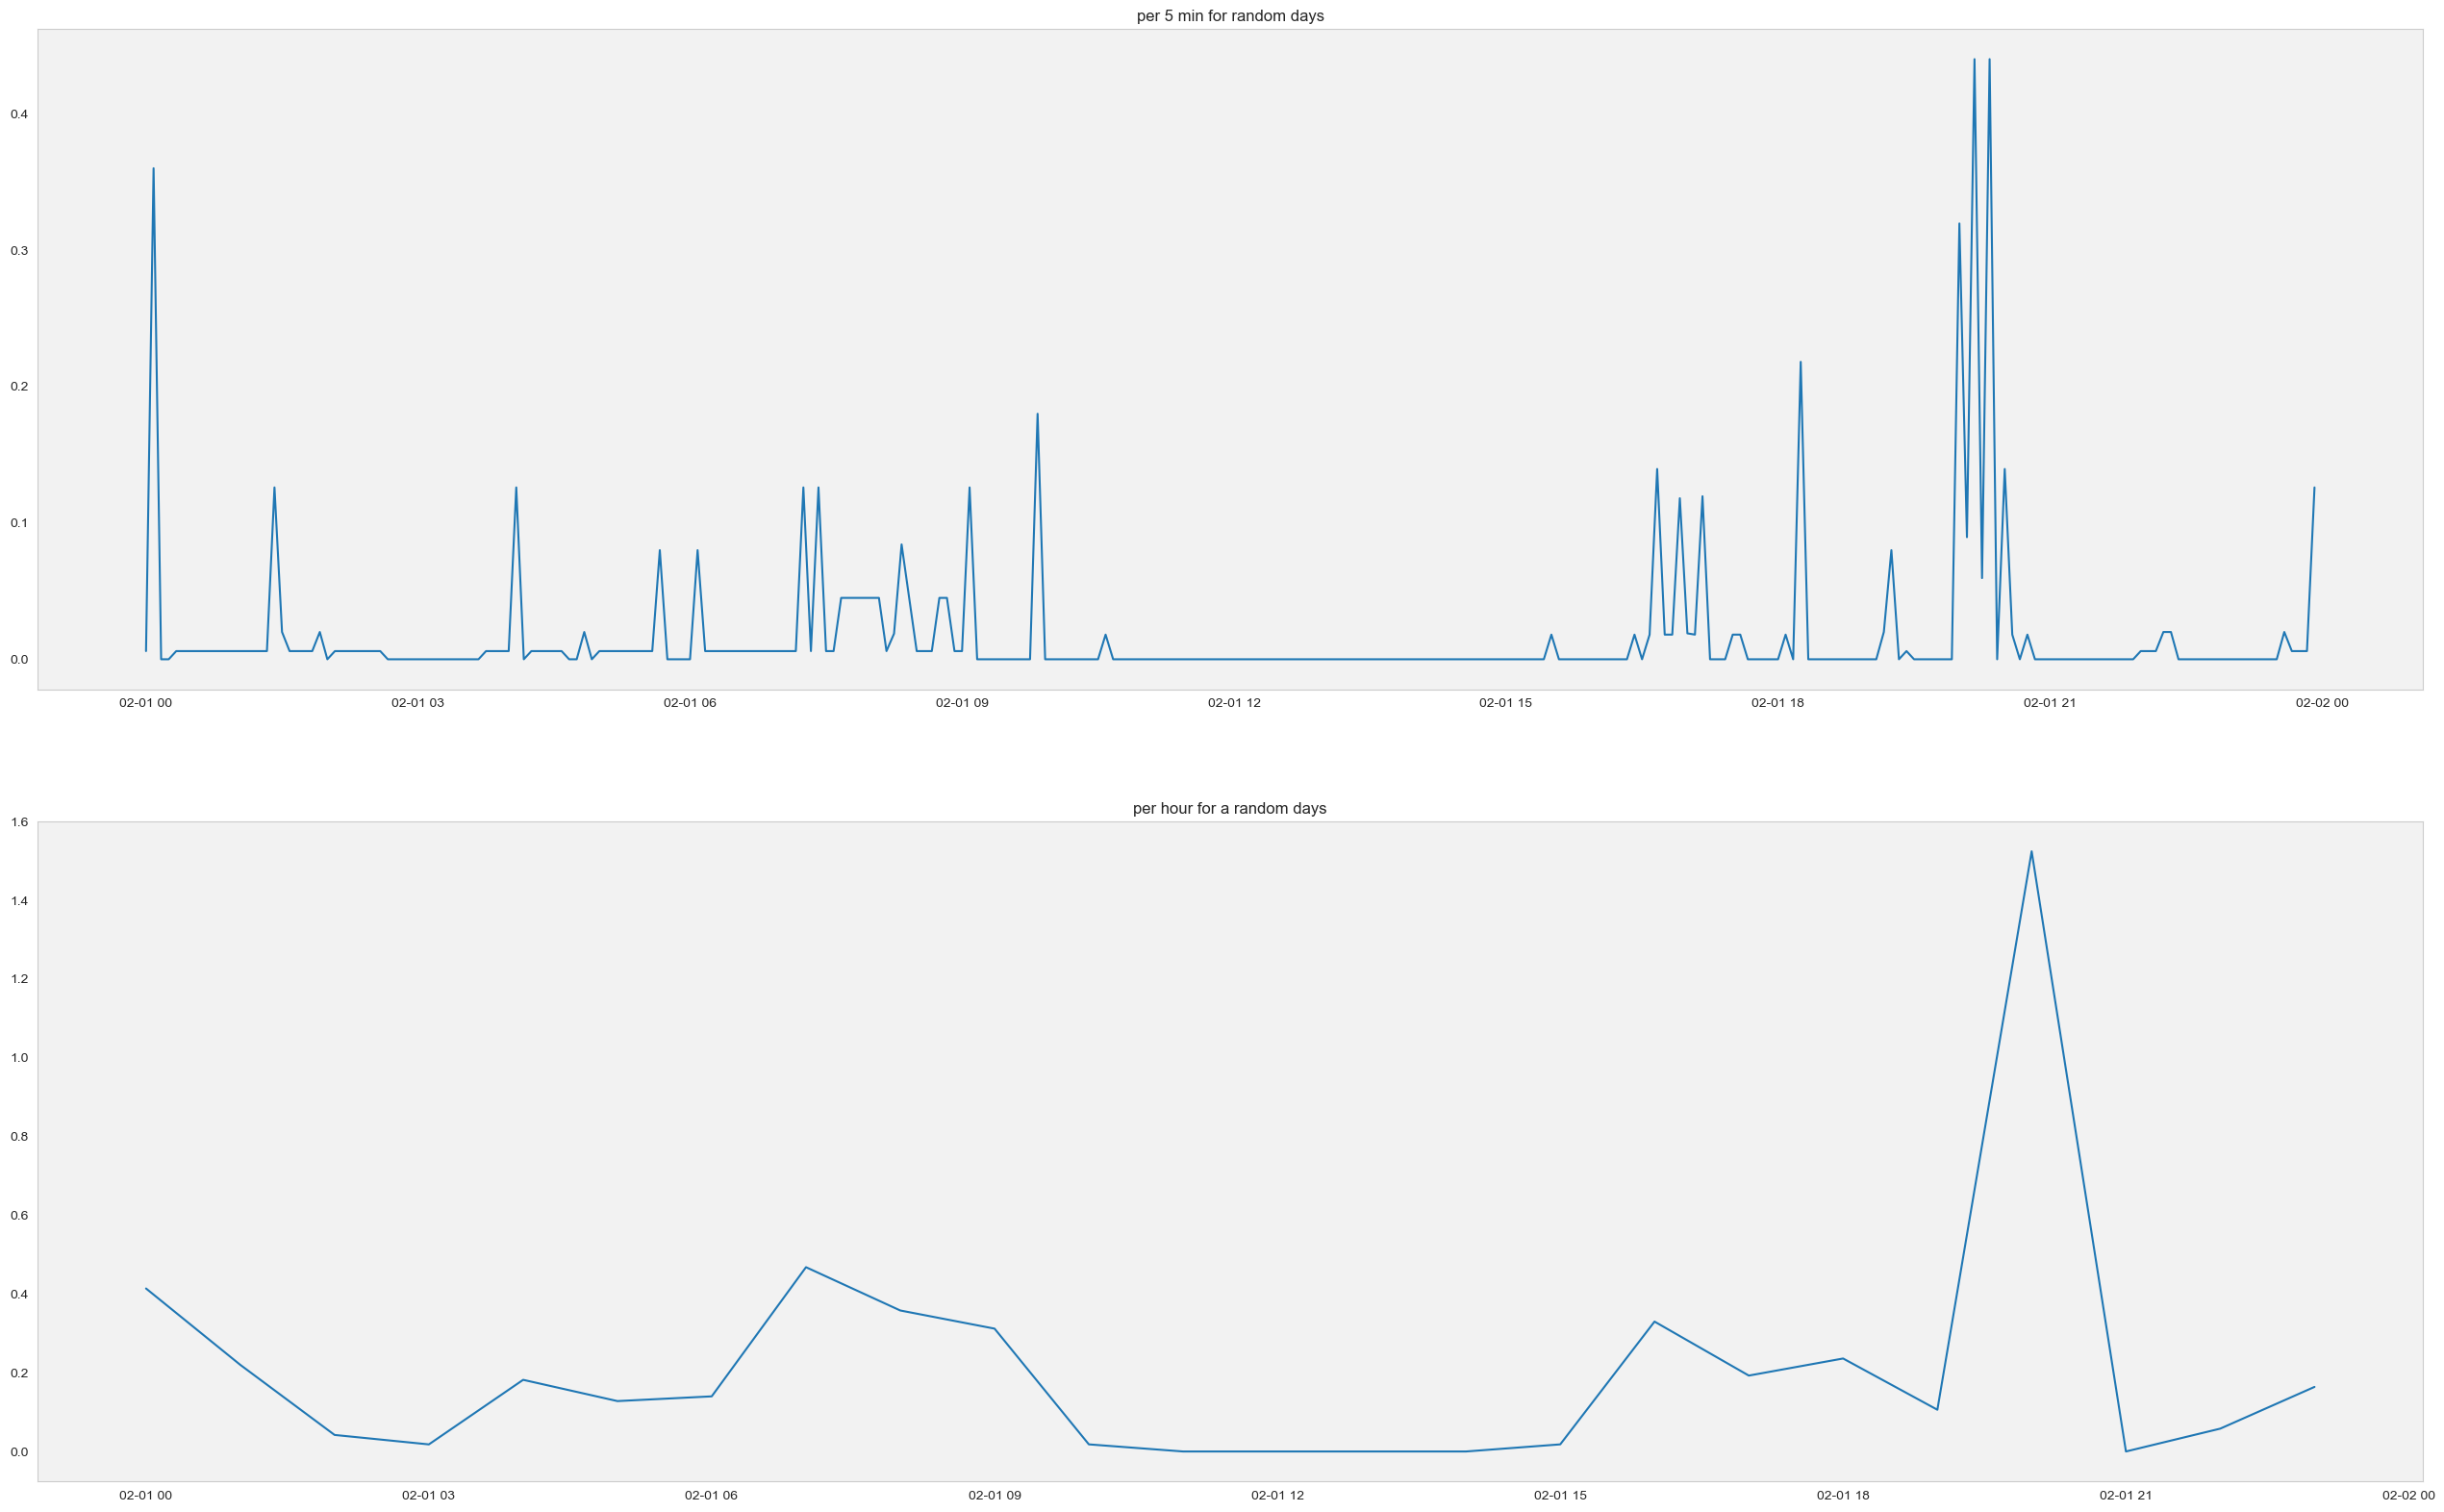

In [14]:
fig, ax = plt.subplots(figsize=(32,20))

plt.subplot(2, 1, 1)
plt.plot(data_per_5min.loc['2015-02-01']['label'])
#plt.plot(data_per_5min['occupancy'])
#plt.plot(data_per_H.loc['2019-05-01':'2019-05-07',:])
plt.title('per 5 min for random days')


plt.subplot(2, 1, 2)
plt.plot(data_per_Hour['2015-02-01']['label'])
#plt.plot(data_per_D.loc['2019-05',:])
plt.title('per hour for a random days')



plt.show()
fig.tight_layout()

In [15]:
# fig = plt.figure(figsize=(20, 15))
# ax1 = fig.add_subplot(211)
# sns.boxplot(data=data, x='month', y='label', ax=ax1)
# ax2 = fig.add_subplot(212)
# sns.boxplot(data=data, x='weekday', y='label', ax=ax2)
# # ax3 = fig.add_subplot(313)
# # sns.boxplot(data=df, x='holiday', y='label', ax=ax3)
# plt.show()

In [16]:
data = data_per_Hour[:]

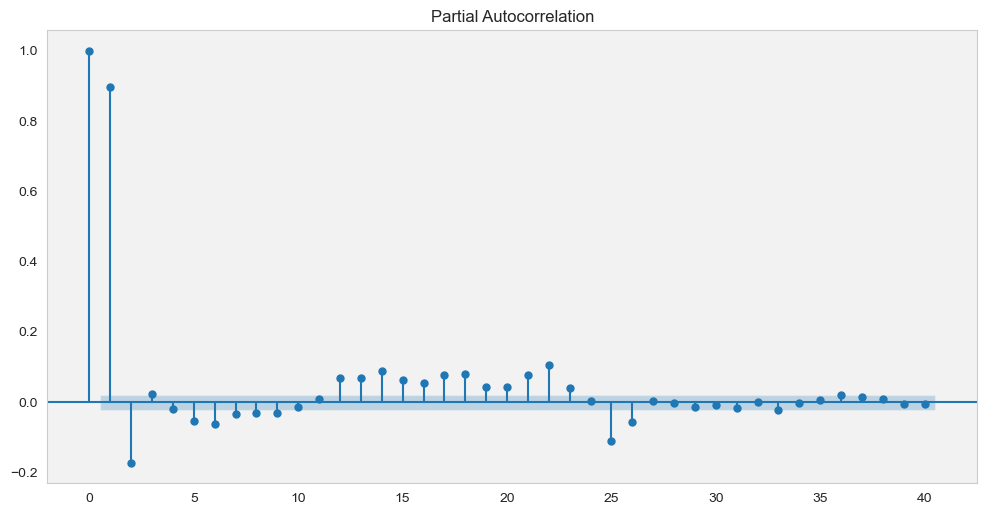

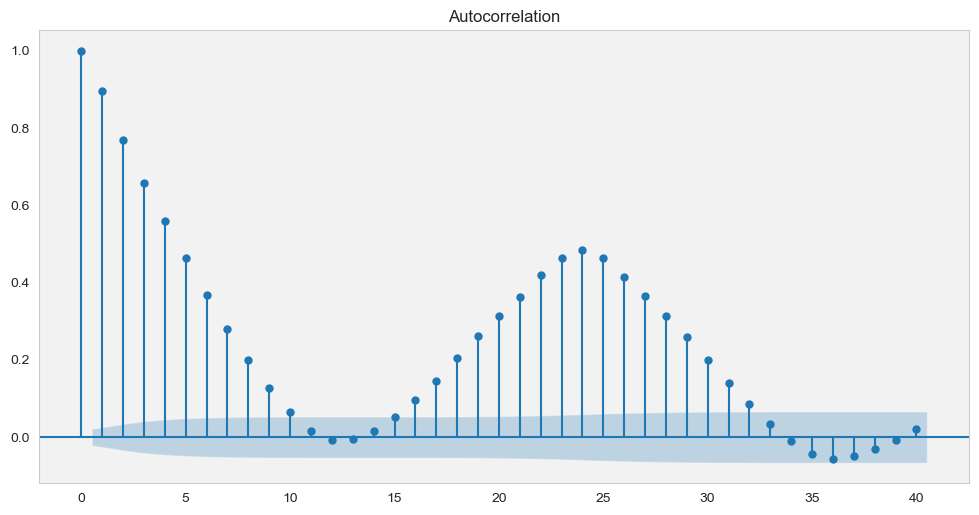

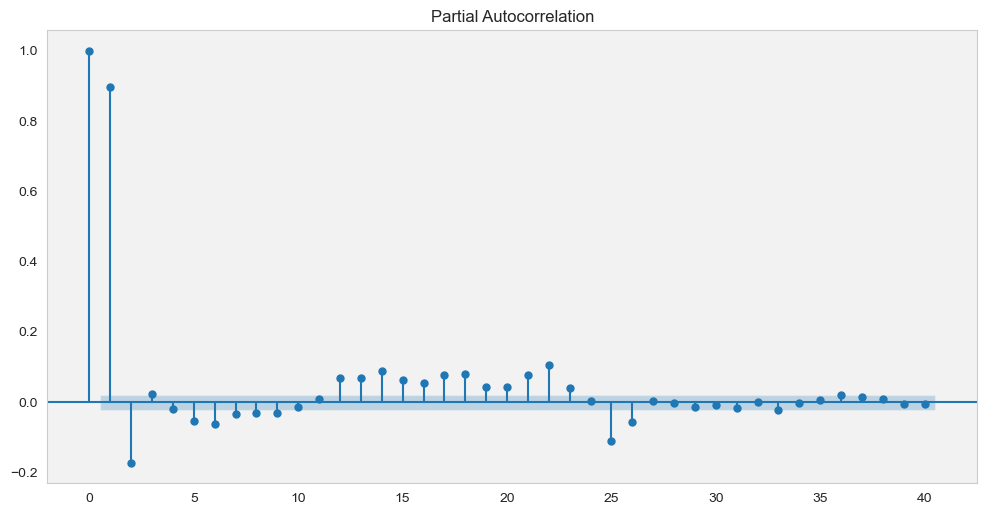

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['label'])
plot_pacf(data['label'])

In [18]:
data.head()

,label
time,
2015-01-06 15:00:00,3.269733
2015-01-06 16:00:00,21.968880
2015-01-06 17:00:00,22.115866
2015-01-06 18:00:00,31.237733
2015-01-06 19:00:00,32.699347


# add simple cal features

In [19]:
import holidays

def add_time_features(df):
    cet_index = df.index
    df["month"] = cet_index.month
    df["weekday"] = cet_index.weekday
    df["hour"] = cet_index.hour
    #df["year"] = cet_index.year
    return df

def add_holiday_features(df):
    de_holidays = holidays.France()
    cet_dates = pd.Series(df.index, index=df.index)
    df["holiday"] = cet_dates.apply(lambda d: d in de_holidays)
    df["holiday"] = df["holiday"].astype(int)
    return df


def add_all_features(df, target_col="conso_global"):
    df = df.copy()
    df = add_time_features(df)
    #df = add_holiday_features(df)
    return df

In [20]:
data = add_all_features(data)

In [21]:
data.head()

,label,month,weekday,hour
time,,,,
2015-01-06 15:00:00,3.269733,1,1,15
2015-01-06 16:00:00,21.968880,1,1,16
2015-01-06 17:00:00,22.115866,1,1,17
2015-01-06 18:00:00,31.237733,1,1,18
2015-01-06 19:00:00,32.699347,1,1,19


## Importing the calendar

In [22]:
from icalendar import Calendar, Event
from datetime import datetime

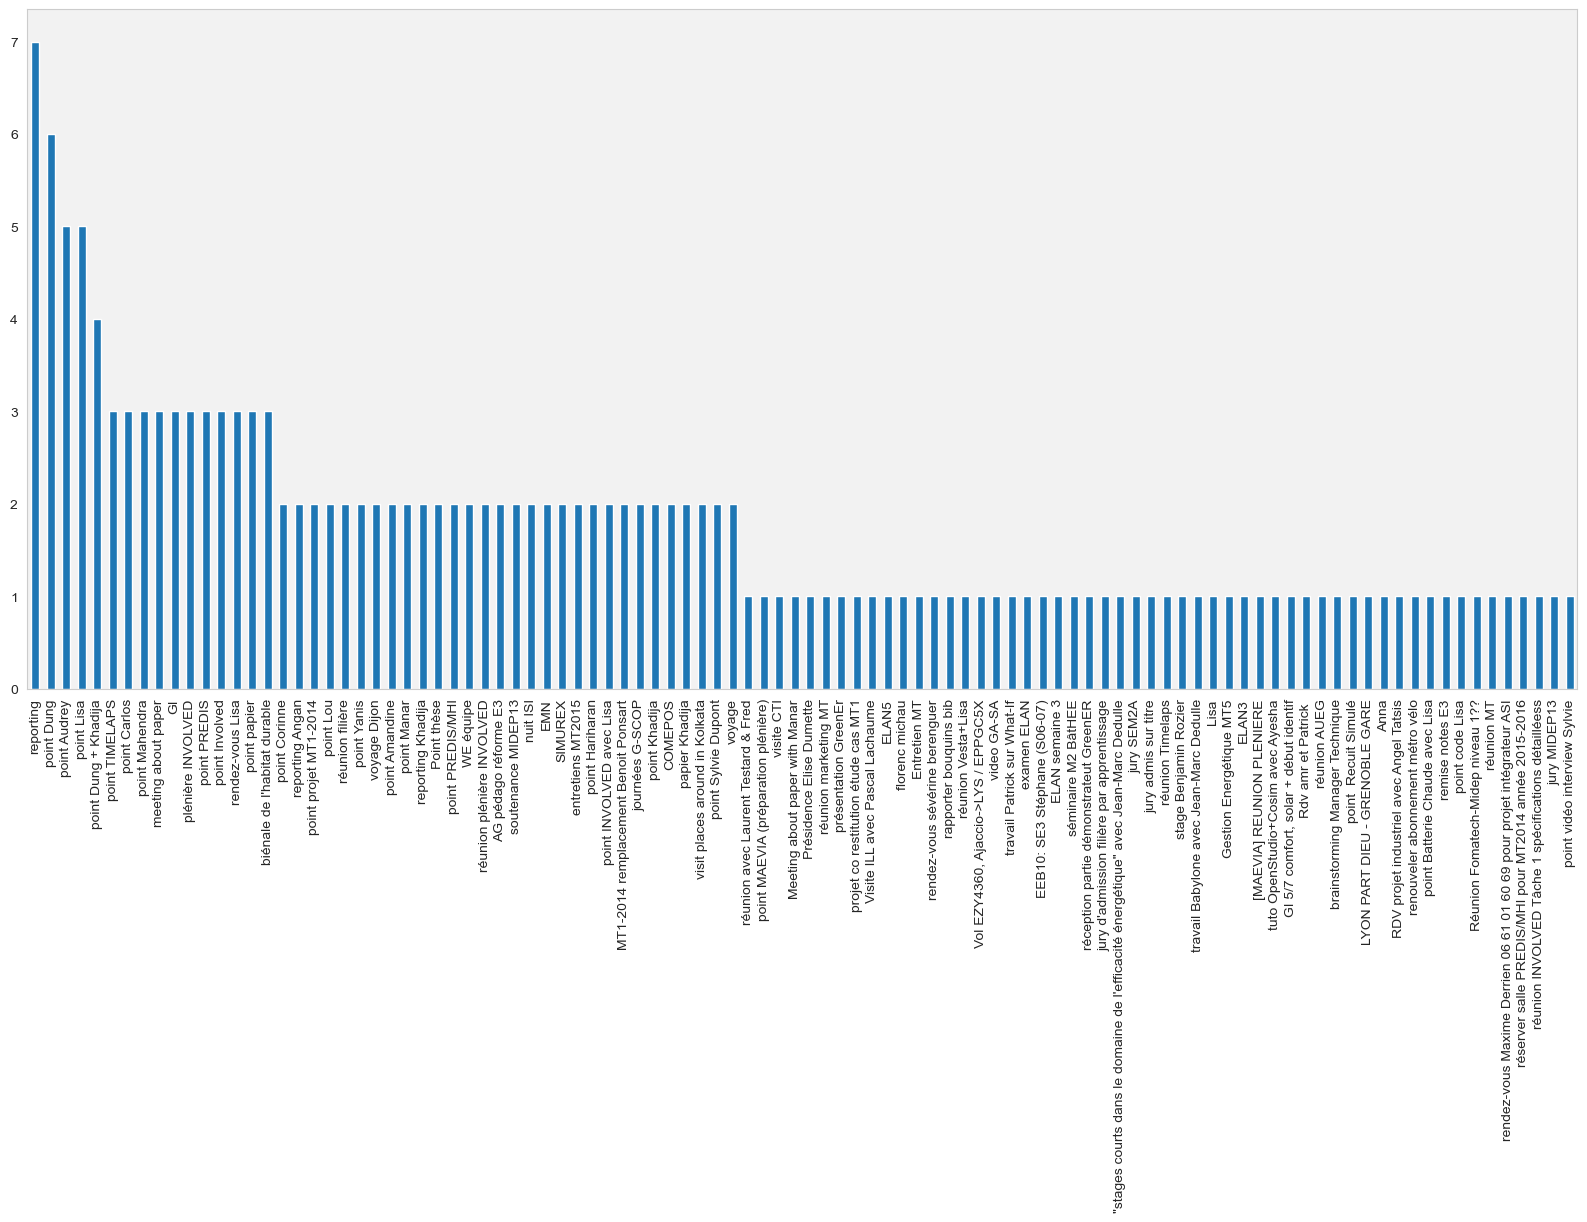

                                         evenement               debut  \
debut                                                                    
2015-01-05 09:15:00                          POO13 2015-01-05 09:15:00   
2015-01-05 15:00:00        point Murielle sur DPEA 2015-01-05 15:00:00   
2015-01-06 13:00:00                réunion mission 2015-01-06 13:00:00   
2015-01-07 07:30:00              Rdv projet Ayesha 2015-01-07 07:30:00   
2015-01-07 08:30:00  appeler amandine pour facture 2015-01-07 08:30:00   

                                           fin  label  
debut                                                  
2015-01-05 09:15:00  2015-01-05 11:15:00+00:00      1  
2015-01-05 15:00:00  2015-01-05 16:00:00+00:00      2  
2015-01-06 13:00:00  2015-01-06 14:30:00+00:00      1  
2015-01-07 07:30:00  2015-01-07 08:30:00+00:00      1  
2015-01-07 08:30:00  2015-01-07 08:45:00+00:00      1  
Empty DataFrame
Columns: [evenement, debut, fin, label]
Index: []
fin test


In [23]:
evenement = []
debut = []
fin =[]


g = open('stephane_stephane.ploix@gmail.com.ics','rb')
gcal = Calendar.from_ical(g.read().decode())
for component in gcal.walk():
    if component.name == "VEVENT":

        evenement.append(str((component.get('summary'))))
        if len(str(component.get('dtstart').dt)) >12:
            debut.append(datetime.strptime(str(component.get('dtstart').dt)[:-6],'%Y-%m-%d %H:%M:%S'))
        else:
            debut.append(datetime.strptime(str(component.get('dtstart').dt), '%Y-%m-%d'))
        if component.get('dtend') is not None:
            fin.append(component.get('dtend').dt)
        else:
            fin.append("Nan")

g.close()

calendrier = pd.DataFrame({'evenement': evenement,'debut':debut,'fin':fin})
calendrier['debut'] =pd.to_datetime(calendrier.debut)
calendrier.sort_values(['debut'], inplace=True)
calendrier = calendrier.set_index(calendrier['debut'])
calendrier = calendrier['2015-01-04':'2015-12-31']


plt.figure(figsize=(20,9))
calendrier.evenement.value_counts()[0:100].plot.bar()
plt.show()

label = []
for k in calendrier.index:
    if "point" in calendrier['evenement'].loc[str(k)]:
        label.append(2)
    else:
        label.append(1)

calendrier['label']=label
print(calendrier.head())



cal = []
nom = []
for k in data['label']:
    cal.append(0)
    nom.append("None")

data['calendrier'] = cal
data['nom']=nom

calendrier.drop_duplicates(subset ="debut",
                     keep = False, inplace = True)
print(calendrier[calendrier.index.duplicated()])
print("fin test")

for k in calendrier.index:
    if k in data.index:
        data['calendrier'].loc[str(k)] = calendrier['label'].loc[str(k)]
        data['nom'].loc[str(k)] = calendrier['evenement'].loc[str(k)]

# plt.figure(figsize=(20,9))
# data['label'].plot()
# data['calendrier'].plot()
# plt.show()

In [24]:
data.head()

,label,month,weekday,hour,calendrier,nom
time,,,,,,
2015-01-06 15:00:00,3.269733,1,1,15,0,None
2015-01-06 16:00:00,21.968880,1,1,16,0,None
2015-01-06 17:00:00,22.115866,1,1,17,0,None
2015-01-06 18:00:00,31.237733,1,1,18,0,None
2015-01-06 19:00:00,32.699347,1,1,19,0,None


In [25]:
data.drop(['nom'], axis =1, inplace=True)

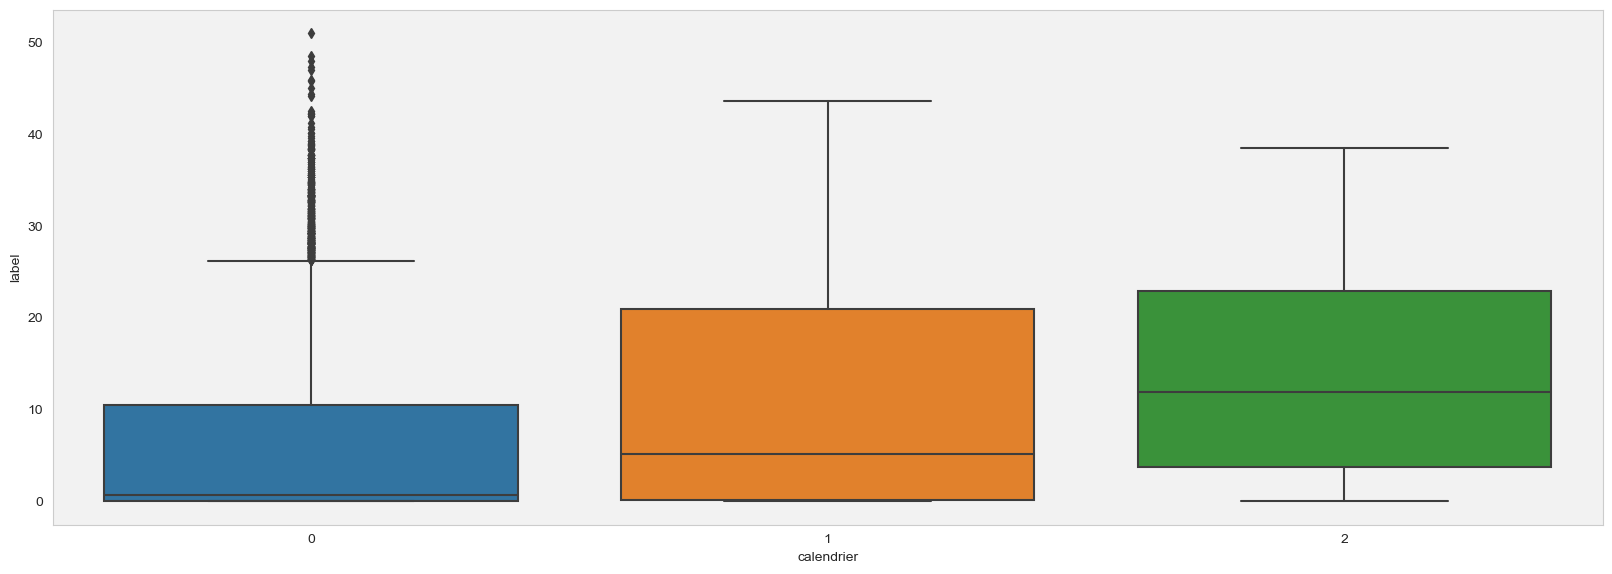

In [26]:
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(211)
sns.boxplot(data=data, x='calendrier', y='label', ax=ax1)
plt.show()

# window 12h: 

In [27]:
# LEADS
leads = np.arange(11)
lead_cols = [f"label_lead_{lead+1}" for lead in leads ]
for lead, lead_col in zip(leads, lead_cols):
    data[lead_col] = data["label"].shift(-(lead+1))

hour_leads = [f"hour_lead_{lead+1}" for lead in leads ]
weekday_leads = [f"weekday_lead_{lead+1}" for lead in leads ]
month_leads = [f"month_lead_{lead+1}" for lead in leads ]
cal_leads = [f"cal_lead_{lead+1}" for lead in leads ]


for lead, lead_H in zip(leads, hour_leads):
    data[lead_H] = data["hour"].shift(-(lead+1))
    
for lead, lead_W in zip(leads, weekday_leads):
    data[lead_W] = data["weekday"].shift(-(lead+1))
    
for lead, lead_M in zip(leads, month_leads):
    data[lead_M] = data["month"].shift(-(lead+1))
    
for lead, lead_C in zip(leads, cal_leads):
    data[lead_C] = data["calendrier"].shift(-(lead+1))    
    


In [28]:
#LAGS
lags = np.arange(1,25)
lag_cols = [f"label_lag_{lag}" for lag in lags ]
for lag, lag_col in zip(lags, lag_cols):
    data[lag_col] = data["label"].shift(lag)
    
hour_lags = [f"hour_lag_{lag}" for lag in lags ]
weekday_lags = [f"weekday_lag_{lag}" for lag in lags ]
month_lags = [f"month_lag_{lag}" for lag in lags ]
cal_lags = [f"cal_lag_{lag}" for lag in lags ]


for lag, lag_H in zip(lags, hour_lags):
    data[lag_H] = data["hour"].shift(lag)
    
for lag, lag_W in zip(lags, weekday_lags):
    data[lag_W] = data["weekday"].shift(lag)
    
for lag, lag_M in zip(lags, month_lags):
    data[lag_M] = data["month"].shift(lag)

for lag, lag_C in zip(lags, cal_lags):
    data[lag_C] = data["calendrier"].shift(lag)
    


        

In [ ]:
#Rolling 

wins = [12, 24, 36, 48, 60]
for win in wins:
    for lag,lag_col in zip(lags, lag_cols):
        data[f"rmean_{lag}_{win}"] = data[lag_col].transform(lambda x : x.rolling(win).mean())
#         data[f"rmax_{lag}_{win}"] = data["label"].shift(lag).transform(lambda x : x.rolling(win).max())
#         data[f"rmin_{lag}_{win}"] = data["label"].shift(lag).transform(lambda x : x.rolling(win).min())
        data[f"rstd_{lag}_{win}"] = data[lag_col].transform(lambda x : x.rolling(win).std())

In [29]:
data.rename(columns={"label": "label_lead_0"}, inplace= True)

In [30]:
data.tail()

,label_lead_0,month,weekday,hour,calendrier,label_lead_1,label_lead_2,label_lead_3,label_lead_4,label_lead_5,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60
time,,,,,,,,,,,,,,,,,,,,,
2015-12-29 20:00:00,0.00,12,1,20,0,0.14,0.11,0.12,0.06,NaN,...,2.376827,3.090452,2.485427,3.171680,2.566877,3.207862,2.567506,3.207641,2.590233,3.194756
2015-12-29 21:00:00,0.14,12,1,21,0,0.11,0.12,0.06,NaN,NaN,...,2.268227,3.003039,2.376827,3.090452,2.485427,3.171680,2.566877,3.207862,2.567506,3.207641
2015-12-29 22:00:00,0.11,12,1,22,0,0.12,0.06,NaN,NaN,NaN,...,2.187934,2.910382,2.268227,3.003039,2.376827,3.090452,2.485427,3.171680,2.566877,3.207862
2015-12-29 23:00:00,0.12,12,1,23,0,0.06,NaN,NaN,NaN,NaN,...,2.089274,2.808858,2.187934,2.910382,2.268227,3.003039,2.376827,3.090452,2.485427,3.171680
2015-12-30 00:00:00,0.06,12,2,0,0,NaN,NaN,NaN,NaN,NaN,...,1.990514,2.699857,2.089274,2.808858,2.187934,2.910382,2.268227,3.003039,2.376827,3.090452


In [31]:
data.dropna(inplace=True)

In [32]:
data.tail()

,label_lead_0,month,weekday,hour,calendrier,label_lead_1,label_lead_2,label_lead_3,label_lead_4,label_lead_5,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60
time,,,,,,,,,,,,,,,,,,,,,
2015-12-29 09:00:00,0.000000,12,1,9,0,0.699200,2.270400,1.292309,1.098200,1.191491,...,2.761799,3.087255,2.786399,3.070711,2.810999,3.053877,2.832964,3.039176,2.825156,3.042098
2015-12-29 10:00:00,0.699200,12,1,10,0,2.270400,1.292309,1.098200,1.191491,1.323055,...,2.737532,3.103214,2.761799,3.087255,2.786399,3.070711,2.810999,3.053877,2.832964,3.039176
2015-12-29 11:00:00,2.270400,12,1,11,0,1.292309,1.098200,1.191491,1.323055,1.476000,...,2.712932,3.119193,2.737532,3.103214,2.761799,3.087255,2.786399,3.070711,2.810999,3.053877
2015-12-29 12:00:00,1.292309,12,1,12,0,1.098200,1.191491,1.323055,1.476000,1.500200,...,2.688332,3.134894,2.712932,3.119193,2.737532,3.103214,2.761799,3.087255,2.786399,3.070711
2015-12-29 13:00:00,1.098200,12,1,13,0,1.191491,1.323055,1.476000,1.500200,1.502444,...,2.663732,3.150322,2.688332,3.134894,2.712932,3.119193,2.737532,3.103214,2.761799,3.087255


In [33]:
#Scaling
scaler = MinMaxScaler()
data['label_lead_0'] = scaler.fit_transform(pd.DataFrame(data['label_lead_0']))

leads = np.arange(11)
lead_cols = [f"label_lead_{lead+1}" for lead in leads ]
for lead, lead_col in zip(leads, lead_cols):
    data[lead_col] = scaler.transform(pd.DataFrame(data[lead_col]))
   

lag_cols = [f"label_lag_{lag}" for lag in lags ]
for lag_col in lag_cols:
    data[lag_col] = scaler.transform(pd.DataFrame(data[lag_col]))

    
for win in wins:
    for lag,lag_col in zip(lags, lag_cols):
        data[f"rmean_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rmean_{lag}_{win}"]))
#         data[f"rmax_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rmax_{lag}_{win}"]))
#         data[f"rmin_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rmin_{lag}_{win}"]))
        data[f"rstd_{lag}_{win}"] = scaler.transform(pd.DataFrame(data[f"rstd_{lag}_{win}"]))

In [34]:
# make 12 step window no overlap
data = data.iloc[[i for i in range(0,len(data),12)]]
data

,label_lead_0,month,weekday,hour,calendrier,label_lead_1,label_lead_2,label_lead_3,label_lead_4,label_lead_5,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60
time,,,,,,,,,,,,,,,,,,,,,
2015-01-10 02:00:00,0.000000,1,5,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.093176,0.162702,0.103379,0.175475,0.110411,0.180131,0.117591,0.184195,0.118614,0.183716
2015-01-10 14:00:00,0.589809,1,5,14,0,0.440792,0.238338,0.097323,0.174303,0.141773,...,0.125990,0.205592,0.119746,0.202365,0.109178,0.186020,0.098273,0.166618,0.090035,0.154623
2015-01-11 02:00:00,0.000000,1,6,2,0,0.000000,0.001804,0.000588,0.000000,0.000000,...,0.153598,0.222311,0.153698,0.222242,0.153749,0.222207,0.154127,0.221960,0.154176,0.221925
2015-01-11 14:00:00,0.000000,1,6,14,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.192773,0.233151,0.189930,0.234416,0.188867,0.234988,0.184945,0.236108,0.177622,0.234849
2015-01-12 02:00:00,0.004974,1,0,2,0,0.015529,0.021843,0.038199,0.083686,0.075961,...,0.154499,0.227866,0.158025,0.227070,0.161827,0.226298,0.162574,0.225834,0.163139,0.225463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27 02:00:00,0.021474,12,6,2,0,0.023363,0.021533,0.023363,0.022906,0.025768,...,0.017969,0.018290,0.017513,0.018353,0.017031,0.018428,0.016548,0.018489,0.016066,0.018538
2015-12-27 14:00:00,0.000000,12,6,14,0,0.000000,0.000000,0.000000,0.000000,0.000355,...,0.033392,0.049409,0.031140,0.046698,0.028910,0.043698,0.026838,0.040355,0.024753,0.036588
2015-12-28 02:00:00,0.030106,12,0,2,0,0.037408,0.061694,0.064439,0.040843,0.007161,...,0.053150,0.060432,0.052769,0.060698,0.052379,0.060964,0.052020,0.061212,0.051631,0.061471


In [35]:
707 *0.75

530.25

In [36]:
train_data = data.iloc[0:530]
test_data = data.iloc[530:]

train_data.shape, test_data.shape

((530, 420), (177, 420))

In [37]:
lead_cols

['label_lead_1',
 'label_lead_2',
 'label_lead_3',
 'label_lead_4',
 'label_lead_5',
 'label_lead_6',
 'label_lead_7',
 'label_lead_8',
 'label_lead_9',
 'label_lead_10',
 'label_lead_11']

In [38]:
lead_cols.insert(0, "label_lead_0") 
lead_cols

['label_lead_0',
 'label_lead_1',
 'label_lead_2',
 'label_lead_3',
 'label_lead_4',
 'label_lead_5',
 'label_lead_6',
 'label_lead_7',
 'label_lead_8',
 'label_lead_9',
 'label_lead_10',
 'label_lead_11']

In [39]:
x_train_data = train_data.drop(lead_cols, axis=1)
y_train_data = train_data.loc[:, lead_cols]
x_test_data = test_data.drop(lead_cols, axis=1)
y_test_data = test_data.loc[:, lead_cols]

In [40]:
y_train_data

,label_lead_0,label_lead_1,label_lead_2,label_lead_3,label_lead_4,label_lead_5,label_lead_6,label_lead_7,label_lead_8,label_lead_9,label_lead_10,label_lead_11
time,,,,,,,,,,,,
2015-01-10 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023604,0.458870,0.519696
2015-01-10 14:00:00,0.589809,0.440792,0.238338,0.097323,0.174303,0.141773,0.022883,0.013497,0.003707,0.007590,0.001686,0.004118
2015-01-11 02:00:00,0.000000,0.000000,0.001804,0.000588,0.000000,0.000000,0.000588,0.006535,0.000000,0.000000,0.000000,0.000000
2015-01-11 14:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000355,0.000353,0.001412,0.001412
2015-01-12 02:00:00,0.004974,0.015529,0.021843,0.038199,0.083686,0.075961,0.111760,0.495158,0.483788,0.471921,0.517523,0.503468
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-29 14:00:00,0.372914,0.421254,0.458821,0.499441,0.323518,0.262002,0.242507,0.083739,0.011940,0.005584,0.007230,0.007230
2015-09-30 02:00:00,0.007230,0.000392,0.000000,0.032995,0.007059,0.000000,0.059814,0.603113,0.573188,0.428225,0.372558,0.261057
2015-09-30 14:00:00,0.267007,0.356133,0.330306,0.341235,0.338754,0.271536,0.053768,0.042394,0.000178,0.000000,0.000000,0.000000


In [41]:
import lightgbm as lgbm
from sklearn import metrics
from sklearn import model_selection

In [42]:
threshold = -2
features = []
for col in y_train_data.columns:
    correlation = pd.DataFrame(train_data.drop(lead_cols, axis=1).corrwith(train_data[col]), columns=['corr'])
    thresh_corr = correlation[correlation['corr']> threshold]
    features.append(list(thresh_corr.index))

In [43]:
pd.DataFrame(features)

,0,1,2,3,4,5,6,7,8,9,...,398,399,400,401,402,403,404,405,406,407
0,month,weekday,hour,calendrier,hour_lead_1,hour_lead_2,hour_lead_3,hour_lead_4,hour_lead_5,hour_lead_6,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60
1,month,weekday,hour,calendrier,hour_lead_1,hour_lead_2,hour_lead_3,hour_lead_4,hour_lead_5,hour_lead_6,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60
2,month,weekday,hour,calendrier,hour_lead_1,hour_lead_2,hour_lead_3,hour_lead_4,hour_lead_5,hour_lead_6,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60
3,month,weekday,hour,calendrier,hour_lead_1,hour_lead_2,hour_lead_3,hour_lead_4,hour_lead_5,hour_lead_6,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60
4,month,weekday,hour,calendrier,hour_lead_1,hour_lead_2,hour_lead_3,hour_lead_4,hour_lead_5,hour_lead_6,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60
5,month,weekday,hour,calendrier,hour_lead_1,hour_lead_2,hour_lead_3,hour_lead_4,hour_lead_5,hour_lead_6,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60
6,month,weekday,hour,calendrier,hour_lead_1,hour_lead_2,hour_lead_3,hour_lead_4,hour_lead_5,hour_lead_6,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60
7,month,weekday,hour,calendrier,hour_lead_1,hour_lead_2,hour_lead_3,hour_lead_4,hour_lead_5,hour_lead_6,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60
8,month,weekday,hour,calendrier,hour_lead_1,hour_lead_2,hour_lead_3,hour_lead_4,hour_lead_5,hour_lead_6,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60
9,month,weekday,hour,calendrier,hour_lead_1,hour_lead_2,hour_lead_3,hour_lead_4,hour_lead_5,hour_lead_6,...,rmean_20_60,rstd_20_60,rmean_21_60,rstd_21_60,rmean_22_60,rstd_22_60,rmean_23_60,rstd_23_60,rmean_24_60,rstd_24_60


In [44]:
from tqdm import tqdm

result = pd.DataFrame()
models = dict()
for counter, col in enumerate(tqdm(y_train_data.columns)):
    
    result[f'pred_{counter}'] = np.zeros(y_test_data.shape[0])
    
    used_features = features[counter]
    
    x_train_local = x_train_data.loc[:, used_features]
    y_train_local = y_train_data.loc[:, col]
    x_test_local = x_test_data.loc[:, used_features]
    y_test_local = y_test_data.loc[:, col]
    
    
    model = lgbm.LGBMRegressor(
        objective='regression',
        max_depth=5,
        num_leaves=5 ** 2 - 1,
        learning_rate=0.007,
        n_estimators=30000,
        min_child_samples=80,
        subsample=0.8,
        colsample_bytree=1,
        reg_alpha=0,
        reg_lambda=0,
        random_state=np.random.randint(10e6)
    )

    n_splits = 6
    cv = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=42)

    val_scores = [0] * n_splits




    #feature_importances = pd.DataFrame(index=x_train_local.columns)

    for i, (fit_idx, val_idx) in enumerate(cv.split(x_train_local, y_train_local)):

        X_fit = x_train_local.iloc[fit_idx]
        y_fit = y_train_local.iloc[fit_idx]
        X_val = x_train_local.iloc[val_idx]
        y_val = y_train_local.iloc[val_idx]

        model.fit(
            X_fit,
            y_fit,
            eval_set=[(X_fit, y_fit), (X_val, y_val)],
            eval_names=('fit', 'val'),
            eval_metric='l2',
            early_stopping_rounds=200,
            feature_name=X_fit.columns.tolist(),
            verbose=False
        )

        val_scores[i] = np.sqrt(model.best_score_['val']['l2'])
        result[f'pred_{counter}'] += model.predict(x_test_local, num_iteration=model.best_iteration_)
        #feature_importances[i] = model.feature_importances_

        print('Fold {} RMSLE: {:.5f}'.format(i+1, val_scores[i]))

    result[f'pred_{counter}'] /= n_splits
    result[f'pred_{counter}'] = np.expm1(result[f'pred_{counter}'])

    val_mean = np.mean(val_scores)
    val_std = np.std(val_scores)

    print('Local RMSLE: {:.5f} (±{:.5f})'.format(val_mean, val_std))
    models[col] = model

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

Fold 1 RMSLE: 0.05815
Fold 2 RMSLE: 0.08403
Fold 3 RMSLE: 0.10541
Fold 4 RMSLE: 0.08142
Fold 5 RMSLE: 0.08789


  8%|██████▉                                                                            | 1/12 [00:05<01:05,  5.94s/it]

Fold 6 RMSLE: 0.10205
Local RMSLE: 0.08649 (±0.01548)
Fold 1 RMSLE: 0.07439
Fold 2 RMSLE: 0.09303
Fold 3 RMSLE: 0.09796
Fold 4 RMSLE: 0.09933
Fold 5 RMSLE: 0.09834


 17%|█████████████▊                                                                     | 2/12 [00:10<00:56,  5.64s/it]

Fold 6 RMSLE: 0.09126
Local RMSLE: 0.09238 (±0.00857)
Fold 1 RMSLE: 0.08598
Fold 2 RMSLE: 0.08976
Fold 3 RMSLE: 0.09937
Fold 4 RMSLE: 0.11356
Fold 5 RMSLE: 0.10981


 25%|████████████████████▊                                                              | 3/12 [00:15<00:49,  5.45s/it]

Fold 6 RMSLE: 0.10000
Local RMSLE: 0.09975 (±0.00985)
Fold 1 RMSLE: 0.10212
Fold 2 RMSLE: 0.09320
Fold 3 RMSLE: 0.13551
Fold 4 RMSLE: 0.11034
Fold 5 RMSLE: 0.11375


 33%|███████████████████████████▋                                                       | 4/12 [00:18<00:37,  4.65s/it]

Fold 6 RMSLE: 0.11507
Local RMSLE: 0.11166 (±0.01303)
Fold 1 RMSLE: 0.09416
Fold 2 RMSLE: 0.09084
Fold 3 RMSLE: 0.13763
Fold 4 RMSLE: 0.10542
Fold 5 RMSLE: 0.10444


 42%|██████████████████████████████████▌                                                | 5/12 [00:22<00:30,  4.39s/it]

Fold 6 RMSLE: 0.12128
Local RMSLE: 0.10896 (±0.01609)
Fold 1 RMSLE: 0.10277
Fold 2 RMSLE: 0.09680
Fold 3 RMSLE: 0.12830
Fold 4 RMSLE: 0.09751
Fold 5 RMSLE: 0.10086


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:27<00:27,  4.56s/it]

Fold 6 RMSLE: 0.13214
Local RMSLE: 0.10973 (±0.01467)
Fold 1 RMSLE: 0.10072
Fold 2 RMSLE: 0.11038
Fold 3 RMSLE: 0.13154
Fold 4 RMSLE: 0.10211
Fold 5 RMSLE: 0.10841


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:32<00:23,  4.67s/it]

Fold 6 RMSLE: 0.11962
Local RMSLE: 0.11213 (±0.01065)
Fold 1 RMSLE: 0.11647
Fold 2 RMSLE: 0.13400
Fold 3 RMSLE: 0.14681
Fold 4 RMSLE: 0.11385
Fold 5 RMSLE: 0.13827


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:36<00:18,  4.61s/it]

Fold 6 RMSLE: 0.13314
Local RMSLE: 0.13042 (±0.01169)
Fold 1 RMSLE: 0.13987
Fold 2 RMSLE: 0.12111
Fold 3 RMSLE: 0.15636
Fold 4 RMSLE: 0.14835
Fold 5 RMSLE: 0.16712


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:40<00:12,  4.28s/it]

Fold 6 RMSLE: 0.14919
Local RMSLE: 0.14700 (±0.01426)
Fold 1 RMSLE: 0.13049
Fold 2 RMSLE: 0.12244
Fold 3 RMSLE: 0.15016
Fold 4 RMSLE: 0.14138
Fold 5 RMSLE: 0.14803


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:44<00:08,  4.28s/it]

Fold 6 RMSLE: 0.13348
Local RMSLE: 0.13766 (±0.00982)
Fold 1 RMSLE: 0.13510
Fold 2 RMSLE: 0.10841
Fold 3 RMSLE: 0.15090
Fold 4 RMSLE: 0.12932
Fold 5 RMSLE: 0.13024


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:48<00:04,  4.19s/it]

Fold 6 RMSLE: 0.13947
Local RMSLE: 0.13224 (±0.01284)
Fold 1 RMSLE: 0.12842
Fold 2 RMSLE: 0.11039
Fold 3 RMSLE: 0.15111
Fold 4 RMSLE: 0.10616
Fold 5 RMSLE: 0.14171


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:53<00:00,  4.42s/it]

Fold 6 RMSLE: 0.12954
Local RMSLE: 0.12789 (±0.01587)


In [45]:
result

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11
0,-0.016614,-0.024327,-0.016756,-0.005632,-0.010482,0.011771,0.036331,0.106181,0.172886,0.194627,0.197877,0.130499
1,0.584147,0.616800,0.587819,0.466604,0.431876,0.402955,0.219547,0.160690,0.087670,0.001970,-0.023868,-0.043791
2,0.362318,0.247475,0.219153,0.262128,0.179648,0.175456,0.138252,0.158370,0.123781,0.135424,0.223694,0.182264
3,0.076568,0.087638,0.101229,0.144250,0.132588,0.125223,0.096053,0.115793,0.165798,0.139582,0.073143,0.031530
4,0.009892,0.060585,0.032438,0.032698,0.010720,0.038670,0.019572,0.045129,0.046512,0.048384,0.018636,0.003494
...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.213625,0.149677,0.143311,0.119242,0.079149,0.069935,0.056441,0.068833,0.037539,0.028819,0.036988,0.042878
173,0.010749,-0.002264,0.003537,0.004823,0.011875,0.041048,0.047941,-0.004577,0.057743,0.066020,0.045908,0.039738
174,0.064550,0.081362,0.056978,0.067438,0.060018,0.033039,0.036227,0.147722,0.214918,0.236197,0.215403,0.225991
175,-0.006758,0.003068,0.009715,0.012758,0.015378,0.014819,0.027680,0.079143,0.112892,0.091474,0.078705,0.073926


In [46]:
final_test = y_test_data.values.flatten()
final_resut = result.values.flatten()

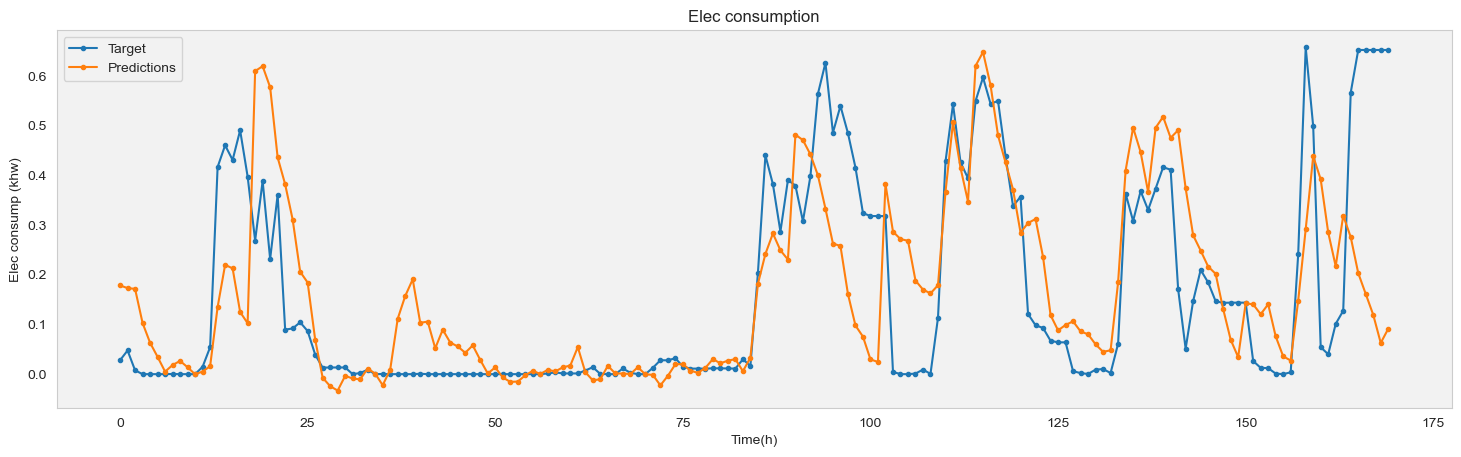

In [47]:
plt.figure(figsize=(18,5))

plt.plot(final_test[330:500], marker='.',label='Target')
plt.plot(final_resut[330:500], marker='.', label='Predictions')
plt.title('Elec consumption')
plt.xlabel('Time(h)')
plt.ylabel('Elec consump (khw)')
plt.legend()
plt.show()

In [48]:
print( "The RMSE for Stacked LSTM model is: %f" %np.sqrt(mean_squared_error(final_test,final_resut)))
print( "The accuracy of Stacked LSTM model is: %f" %r2_score(final_test,final_resut))

The RMSE for Stacked LSTM model is: 0.146332
The accuracy of Stacked LSTM model is: 0.491843
